**Blog Post 2: 'Optimal' Decision Making**

Introduction: In this post, I analyze data, construct a logistic regression model, and make predictions on a test dataset to understand a simplified but relatively realistic decisionmaking process in the highly important task of determining whether to make a loan to a borrower given information on their personal finances, their requested loan, and their employment history. I find that a bank can maximize its profits by lending to a small number of higher-income individuals with smaller requested loans, longer credit histories, and more years of employment. Loans for different purposes have varying default rates and are correspondingly approved at different rates--medical loans in particular are more often rejected but have the highest default rates. Using a definition of fairness related to minimizing harm, I argue that it is reasonable for a bank to have lower approval ratings for medical loans in order to minimize harm to its own stakeholders.

*I have neither given nor received unauthorized aid on this assignment - James Ohr*


**Part A: Grab the Data**

In [1]:
#Importing the data and storing it in variable df_train

import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

**Part B: Explore the Data**

In [2]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


The above table helps me get a sense of the variables in the dataset and their types.

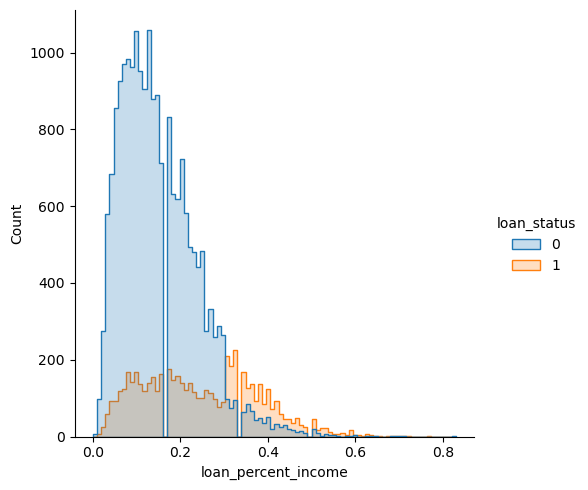

In [3]:
import seaborn as sns
import numpy as np

sns.displot(df_train, x="loan_percent_income", hue="loan_status", element="step")

The above figure shows that there are (1) significantly more borrowers who didn't default than those who did, (2) individuals who receive a loan less than 30% of their income are unlikely to default on their loan, and (3) individuals who receive a loan over 30% of their income are significantly more likely to default than not.

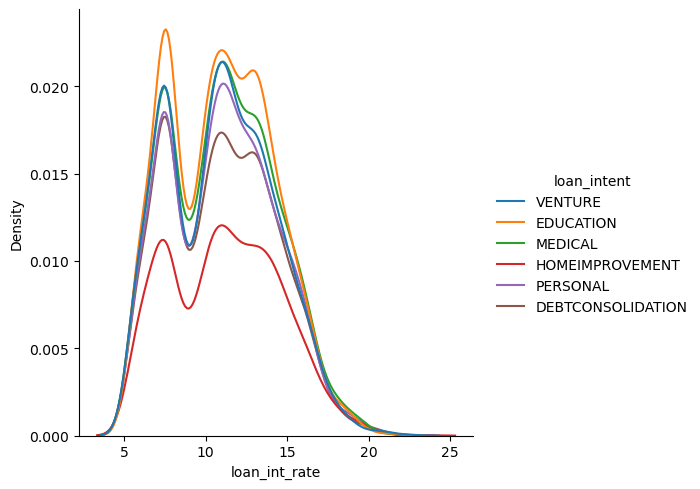

In [4]:
sns.displot(df_train, x="loan_int_rate", hue="loan_intent", kind="kde")

The above figure shows an interesting pattern across every single type of loan. Each distribution is approximately bimodal (although some have three local maxima). It's unsurprising, but there are far more people under the second peak, i.e., the higher interest rate peak, for each type of loan.

In [5]:
df_train.groupby("loan_intent").mean(numeric_only=True)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
loan_intent,,,,,,,,
DEBTCONSOLIDATION,27.588798,66693.453327,4.759419,9620.901149,10.983305,0.287458,0.170869,5.695548
EDUCATION,26.597620,63847.711917,4.440192,9460.015604,10.965465,0.173396,0.169352,5.141603
HOMEIMPROVEMENT,28.981737,73082.079600,5.103754,10348.725017,11.160075,0.264645,0.166733,6.430048
MEDICAL,27.950982,61314.583868,4.782062,9242.269907,11.051946,0.263289,0.172825,5.913547
PERSONAL,28.288339,68070.502495,4.897997,9549.427178,11.009814,0.193739,0.168671,6.151316
VENTURE,27.588643,66098.818162,4.877869,9516.417425,10.940866,0.148678,0.170130,5.744040


Borrowers intending to use loans for home improvement tend to (1) have higher incomes, (2) receive greater loans, and (3) tend to have higher default rates, which are in line with default rates of loans for medical and debt consolidation.

Medical loan borrowers tend to have the lowest incomes, the highest loan-to-income ratios, and the lowest loan amounts. The first observation is most surprising--I would have expected education loan borrowers to have the lowest incomes (maybe this has to do with co-signers).

**Part C: Build a Model**

The below code pre-processes our data for use in the model. We drop the "loan_grade" variable, which the instructions disallow for building th emodel. We separate out "loan status" into an outcome variable, y. We transform categorical variables from strings into numbers. 

In [6]:
#Data pre-processing

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def prepare_data(df):
  df = df_train.drop(["loan_grade"], axis = 1)
  df = df.dropna()
  le.fit(df_train["person_home_ownership"])
  df["person_home_ownership"] = le.transform(df["person_home_ownership"])
  le.fit(df_train["loan_intent"])
  df["loan_intent"] = le.transform(df["loan_intent"])
  y = df["loan_status"]
  df = df.drop(["loan_status"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(df_train)
df_train = df_train.dropna()

Below, I chose the features for the model and fitted our model to our training data. I chose income and loan amount because they're the two components of the loan-to-income ratio, which seemed to be relatively revealing in the above chart showing loan status vs. loan-to-income. Adding employment length didn't actually change the accuracy of the model, but I added it just because intuitively I thought it might have an impact even though the table above didn't show anything particularly interesting regarding the variable.

In [7]:
#Choosing features
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

cols = ["person_income", "loan_amnt", "person_emp_length"]

LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)
LR.coef_[0]

array([-4.05735465e-05,  1.06559046e-04, -2.48736069e-08])

**Part D: Find a Threshold**

Below we have code that (1) finds the profit the bank makes from all of its loans (we ignore any NAs) and (2) identifies the threshold that maximizes profit.

In [8]:
#This function, taken from the week 2 lecture notes and just slightly modified to allow for a third x variable, calculates the risk score for a borrower. 
def linear_score(w, x0, x1, x2):
    return w[0]*x0 + w[1]*x1 + w[2]*x2

In [9]:
#Predict makes binary predictions for data using a supplied score function with weights w and a supplied threshold. Taken from lecture notes from week 2.
#We begin with a 0 threshold but later on test others to find an optimal threshold

t = 0

def predict(score_fun, w, threshold, df):
    """
    make binary predictions for data df using a supplied score function with weights w and supplied threshold. 
    """
    scores = score_fun(w, df["person_income"], df["loan_amnt"], df["person_emp_length"])
    return 1*(scores > threshold)

df_train["decision"] = predict(linear_score, LR.coef_[0], t, df_train)
(df_train["decision"] == df_train["loan_status"]).mean()

0.8080062862880342

In [10]:
# Creating a funciton to find profit
#The loan_int_rate variable is expressed as a percentage, so we divide it by 100 to make it a regular proportion instead in both helper variables

#Helper function to calculate profit for when loans are repaid, using the provided formula
def calculateGain(loan_amnt, loan_int_rate):
    return np.sum(loan_amnt*(1 + 0.25*loan_int_rate/100)**10 - loan_amnt) 

#Helper function to calculate loss for when loans are defaulted on, using the provided formula
def calculateLoss(loan_amnt, loan_int_rate):
    return np.sum(loan_amnt*(1 + 0.25*loan_int_rate/100)**3 - 1.7*loan_amnt)
    
def find_profit(df):
    #Below df_repaid and df_default are created to select only the data points the model chooses
    df_repaid = df[df["loan_status"] == 0]
    df_repaid = df_repaid[df_repaid["decision"] == 0]
    df_default = df[df["loan_status"] == 1]
    df_default = df_default[df_default["decision"] == 0]
    
    return calculateGain(df_repaid["loan_amnt"], df_repaid["loan_int_rate"]) + calculateLoss(df_default["loan_amnt"], df_default["loan_int_rate"])

find_profit(df_train)

25068803.47746343

The below code just runs find_profit on every integer from -100 to 100 in an attempt to find the threshold that gest us the highest profit. We find that a threshold of -1 corresponds to the highest profit value, which is about $25 million.

(-1.0, 25755817.698476546)

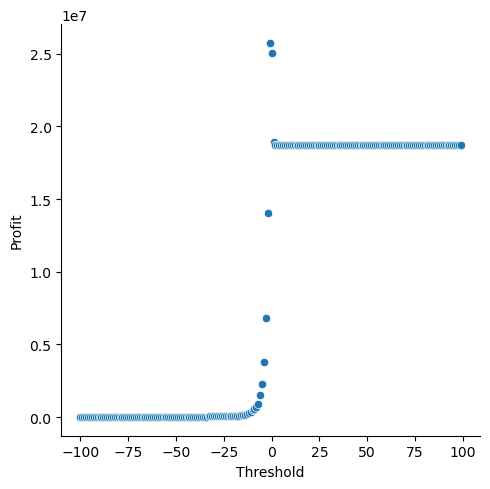

In [11]:
iterations = 200
predictions = []
for i in range(iterations):
    threshold = (-iterations/2)+(i)
    df_train["decision"] = predict(linear_score, LR.coef_[0], threshold, df_train)
    predictions.append((threshold, find_profit(df_train)))


predictions_df = pd.DataFrame(data=predictions)
predictions_df.columns =['Threshold', 'Profit']

sns.relplot(data=predictions_df, x="Threshold", y="Profit")
predictions_df['Threshold'][predictions_df['Profit'].idxmax()], predictions_df['Profit'].max()

**Part E: Evaluate Your Model From the Bank's Perspective**

In [12]:
#In these code block, we find for the training set the total profit of our model, the profit per approved borrower, and the accuracy rate.
final_threshold = -1

df_train["decision"] = predict(linear_score, LR.coef_[0], final_threshold, df_train)
borrowers_count = df_train[df_train["decision"]==0].count()["loan_int_rate"]
find_profit(df_train), find_profit(df_train)/borrowers_count, (df_train["decision"] == df_train["loan_status"]).mean()

(25755817.698476546, 1819.0421426990993, 0.6927576723272362)

In [13]:
#In these code block, we find for the test set the total profit of our model, the profit per approved borrower, and the accuracy rate.
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

df_test["decision"] = predict(linear_score, LR.coef_[0], final_threshold, df_test)
borrowers_count = df_test[df_test["decision"]==0].count()["loan_int_rate"]
find_profit(df_test), find_profit(df_test)/borrowers_count, (df_test["decision"] == df_test["loan_status"]).mean()

(5965836.794978274, 1632.2398891869423, 0.6898879852692957)

*What is the expected profit per borrower on the test set? Is it similar to your profit on the training set?*

The profit per borrower was lower in the test dataset ($1,632) than the training dataset ($1,819), but the accuracy was similar, where accuracy is defined as the % of the time our default prediction actually matched the borrower's default status.

Training accuracy: 69.3%

Testing accuracy: 69.0%

**Part F: Evaluate Your Model From the Borrower’s Perspective**

In [22]:
df_test.groupby(["loan_intent"])[["loan_status", "decision"]].mean(numeric_only=True)

,loan_status,decision
loan_intent,,
DEBTCONSOLIDATION,0.279497,0.386847
EDUCATION,0.167421,0.401961
HOMEIMPROVEMENT,0.246088,0.270270
MEDICAL,0.281553,0.406958
PERSONAL,0.219227,0.385445
VENTURE,0.145701,0.361086


The above table shows us the default rates by loan category, as well as what proportion of borrowers were approved by our model. Medical loans have the highest rejection rates and the highest default rates.

In [15]:
df_test.groupby(["decision"]).mean(numeric_only=True)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
decision,,,,,,,,
0,28.064977,82754.051932,5.244782,8949.870785,10.709193,0.123554,0.115412,6.052670
1,27.189894,39522.220049,4.133252,10859.555827,11.528797,0.381011,0.263394,5.496333


The above table shows us the different average statistics of approved vs. rejected borrowers. Approved borrowers tend to be slightly older, have much higher income, have longer employment histories, ask for smaller loans, ask for loans that represent a smaller proportion of their income, and have longer credit histories.

<Axes: xlabel='person_age', ylabel='decision'>

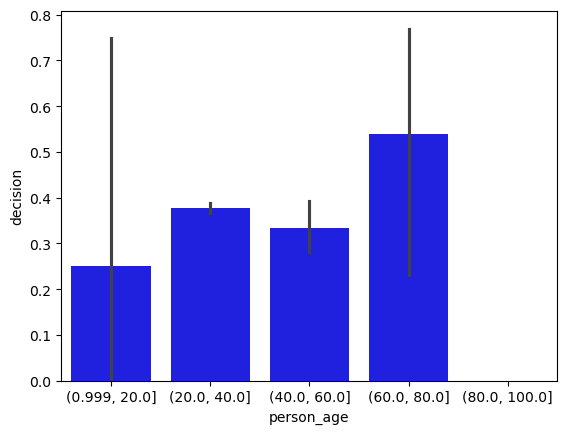

In [16]:
bins = np.array([1,20,40,60,80,100])
df_test["person_age"] = pd.cut(df_test["person_age"].astype('Int64'), bins, include_lowest=True)

sns.barplot(data=df_test, x="person_age", y="decision", color='blue')

The above table shows the average decision rating for each age range (bucketed by 20 years).

Questions:
1. Is it more difficult for people in certain age groups to access credit under your proposed system?
2. Is it more difficult for people to get loans in order to pay for medical expenses? 2a. How does this compare with the actual rate of default in that group?  2b. What about people seeking loans for business ventures or education?
3. How does a person’s income level impact the ease with which they can access credit under your decision system?




Response:

For the purpose of this discussion, we will consider a loan "rejected" if the model deems the loan too-high risk. All statistics are based on the test dataset.

1. While the 20-40 and 40-60 age ranges seem to have about the same access to credit, the 60-80 age group has a significantly higher chance of being rejected--i.e., have lower access to credit. Younger borrowers seem to have the greatest variability in access to credit but generally have high access
2. Compared to loans for other purposes, loans for medical expenses are frequently considered too high-risk to make according to our model. Our model is, in a sense, generous: 28.2% of medical borrowers defaulted, but 40.7% were considered too high-risk. In contrast, business venture loans were denied 36.1% of the time with 14.6% risk of default, so the default rate and rejection rate were even further apart. For loans for education, 40.2% of borrowers were rejected, while 16.7% of borrowers actually defaulted. So even though a 40.7% rejection rate for medical borrowers is higher than loans for other purposes, the rejection rate seems reasonable when we consider the high default rate of medical loans.
3. The higher the income, the lower the perceived risk by the model. This is clearest in the simple table above that groups individuals by the "decision" column results. The borrowers the model would accept have about 13 more months of work experience, request loans that are smaller by about $2,000, and have credit histories that are 6 months longer. But the starkest differences are in (1) the income of the borrower and (2) the percentage of income the loan represented, which is directly related to income. The income of approved borrowers is about double the income of rejected borrowers. The loan-to-income ratio is about three times higher for rejected borrowers than approved borrowers.

**Part G: Write and Reflect**


**Discussion on Fairness**

*Considering that people seeking loans for medical expense have high rates of default, is it fair that it is more difficult for them to obtain access to credit?*

*Fairness*

Fairness in decision-making is to make choices that minimize harm to all parties, with particular regard to parties with low/no control. 

*Control*

The bank has full control over whether to make the loan, so they clearly have substantial control. The borrower has far less control but not no control--excluding cases in which people have a serious illness / injury that prevents them from working, they have some level of control over their personal finances, particularly their income. Still, the borrower has likely little control over the size of the loan they need given the nature of medical expenses and, relatedly, the percentage of income their loan constitutes. So in this way, it's unlikely that a perfectly fair decision can be made. But the bank has to make a decision, and so the goal should be to achieve a target that gets as close to fairness as possible.

*Harm*

It is not only the borrower who can experience harm in this scenario by being denied a loan. The bank experiences financial harm by lending to a borrower with excessively high risk. This harm is harder to see immediately--it's distributed in the form of risk or loss across shareholders, management, employees, depositors, lenders, etc, but it's harm nonetheless. And if a bank were to repeatedly make loans with negative expected value, it risks serious harm to those stakeholders (e.g., people losing savings in the bank's stock; employees losing jobs; depositors losing uninsured deposits).

It's possible the bank could just make loans with lower expected value instead, not negative expected value. But even that could mean a decline in the business over time as competitors generate greater profits and reinvest those profits to become more competitive, harming this bank's business and hence its stakeholders.

In conclusion, balancing the benefit to the bank's stakeholders with the potential harm to rejected borrowers, I conclude that it is fair for medical loan borrowers to have more difficulty accessing credit.

To reach a conclusion about whether this specific model and its decisions are fair, we would have to make assumptions about the level of harm being done to rejected borrowers and the benefit to stakeholders in the bank from those borrowers being rejected.

**Reflection on Blog Post**

I found that it is possible to construct a logistic regression model that can predict borrower outcomes with relative accuracy. One of the most interesting findings was that in this case, to maximize our target variable, we actually didn't optimize accuracy. A threshold of 0 yields around 80% accuracy on the training set, far higher than our profit-maximizing threshold of -1, which yields 69% accuracy on the training set. I learned more about how to visualize data and had to grapple with the best ways to visualize so many variables. I ultimately concluded that I would keep my graphs relatively simple and show a more complete story via tables. I learned to work with subsets of my own data: Part D in particular was tricky for me because I had trouble finding a way to construct the find_profit function.

Unlike the Classifying Penguins post, there was a lot less guidance, which I think was helpful in forcing me to edit and therefore engage further with the example code given previously (e.g.,  pre-processing the data at the start of Part C)
